In [1]:
%load_ext autoreload
%autoreload 2
import glob
import json
import numpy as np
import pandas as pd
import import_lakes

In [2]:
df = import_lakes.import_lake(r'./data/lakegreifenctdprofiles_datalakesdownload/*.json')

In [3]:
import matplotlib.pyplot as plt

In [4]:
df['x'].values[0] / 60 /60 - df['x'].values[8] / 60 /60

-23.608888888848014

# chunk data into days

In [4]:
day_df = pd.DataFrame([df.to_numpy()[i*8:(i+1)*8].mean(axis=0) for i in range(len(df)//8)],columns=df.columns)

In [5]:
day_df

,x,z,z1,z2,z3,z4,z5,z6,z7,z8,z9
0,1.593633e+09,9.914375,0.368563,0.250000,70.923749,7.37500,7.953188,14.26250,-0.25000,3.46875,-0.36875
1,1.593719e+09,10.816688,0.376937,0.249563,90.485001,9.22500,8.042875,13.77500,-0.11875,3.69375,0.29375
2,1.593805e+09,10.702438,0.376812,0.249875,79.800000,8.34375,7.987875,11.38125,-0.13750,3.77500,-1.81875
3,1.593892e+09,10.936375,0.378625,0.250000,82.480000,8.55000,8.012750,10.71875,0.00000,3.83125,-1.71250
4,1.593978e+09,10.504125,0.374938,0.249875,79.435624,8.32500,7.973062,10.49375,-0.04375,3.41250,0.51875
...,...,...,...,...,...,...,...,...,...,...,...
791,1.681658e+09,7.729063,339.412498,463.231247,102.089374,9.02500,10.119812,15.81250,1.80000,2.90000,-3.05625
792,1.681831e+09,7.400437,336.993752,463.937496,96.271875,8.71250,10.044563,12.76875,1.86250,2.25625,-3.07500
793,1.682003e+09,7.876125,342.250000,464.543743,95.108749,8.51875,10.219688,15.11875,2.23750,2.82500,-3.25000
794,1.682176e+09,7.771437,341.250000,464.724998,94.716874,8.37500,10.324188,13.72500,2.35000,2.60625,-1.57500


In [6]:
day_df['x'].values[0] / 60 /60 - day_df['x'].values[1] / 60 /60

-23.95111111109145

### Remove Nones

In [7]:
day_df['z6'] = np.maximum(day_df['z6'],3)

### Ploting style

In [83]:
def initialize_plt(figsize = (6,6),fontsize = 22):
    # initialice Matplotlib
    _=plt.figure()
    plt.rcParams["figure.figsize"] = figsize
    plt.rcParams.update({'font.size': fontsize})
    plt.rcParams.update({'font.family':'Sans'})
    plt.rcParams.update({'lines.linewidth' : 3})
initialize_plt((10,7))

<Figure size 1000x700 with 0 Axes>

### Gaussian Filter

In [84]:
from scipy.ndimage import gaussian_filter1d

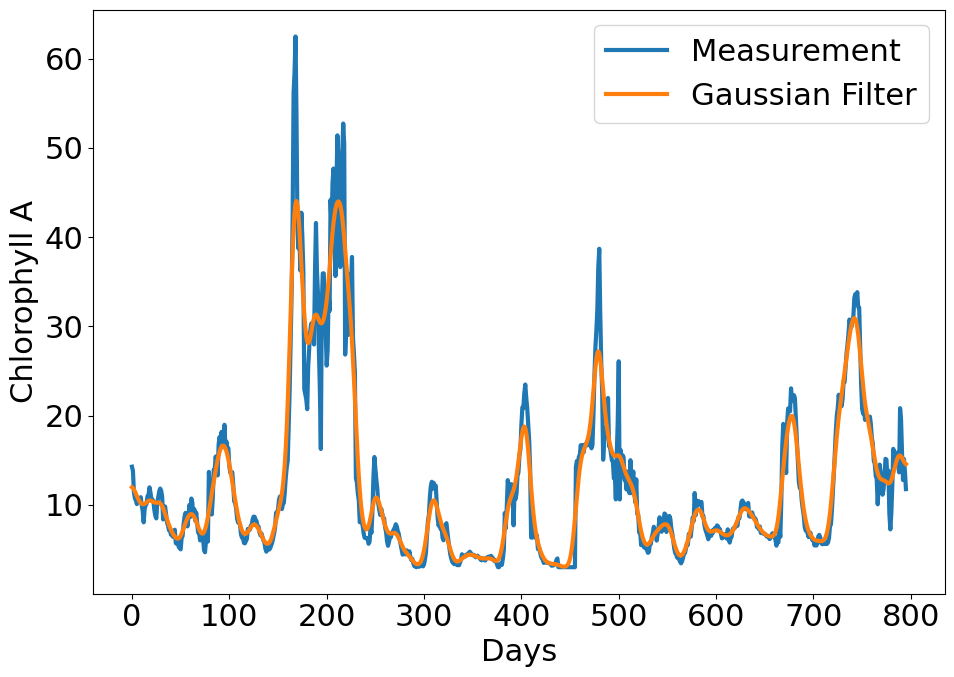

In [108]:
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
ax.plot(day_df['z6'].values,label='Measurement')
ax.plot(gaussian_filter1d(day_df['z6'].values,4),label='Gaussian Filter')
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.legend()
fig.savefig('Plots/ChlorophyllApGauss.png')

#### Train test split

In [109]:
ax.fill_between(range(600,800),0,50, alpha=0.5,color='grey')
fig.savefig('Plots/ChlorophyllApGausstraintest.png')

### Example training evaluation

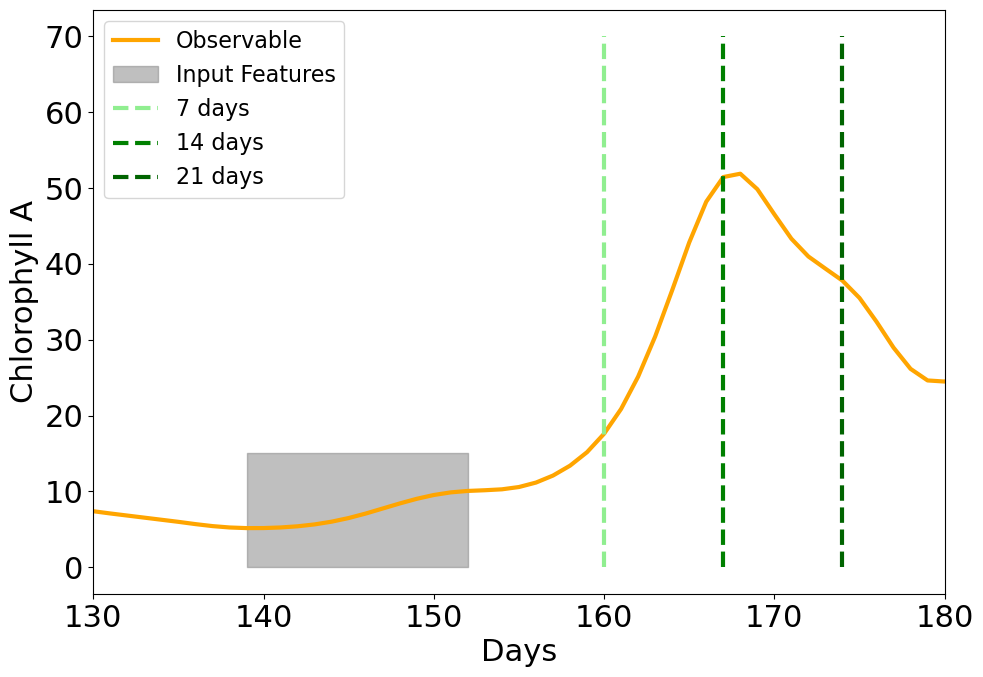

In [110]:
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([130,180])
ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('TrainTestExample.png')

## Create Training Data predict directly

In [212]:
from NN import LSTM_model
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 

In [213]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

## Define LSTM model to predict algea consentration of t+1 based on concentration at t

In [116]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [117]:
model_1 = LSTM_model(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001)

In [118]:
model_1.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
for i in range(250):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_1(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

233.7758631771558
202.10680338454574
167.28785273146957
151.68703397986008
143.75470653298783
138.8572750614114
133.34430229173947
131.77397848808602
125.80592646010935
123.68494074638576
120.35108580001413
117.7883411531579
113.22692952090746
111.92592034927786
109.26289400989062
107.70579872392628
106.4083384944968
104.88864496962665
104.55887788615814
107.8613273476901
101.48609879572098
101.56898967533895
101.12803579356573
99.28180192921259
98.72585961916676
98.20218278937143
97.7511831962899
98.62570383777357
99.65769007434584
97.52137387941961
96.58686504625294
96.6324707449299
96.08149221498672
95.94341586387321
95.77572004762415
96.16542769131595
96.71140290613044
96.35491205241583
97.67562975948805
95.32154667214172
95.29362021407036
95.17679328134615
95.5394835929348
95.17955849268665
95.10583618895649
95.10297895457647
95.05346083967653
95.03026115731018
95.15805727814976
95.08829260525638
95.71409434488375
94.94280893508702
95.23286485018795
95.13090590908102
98.3487840417

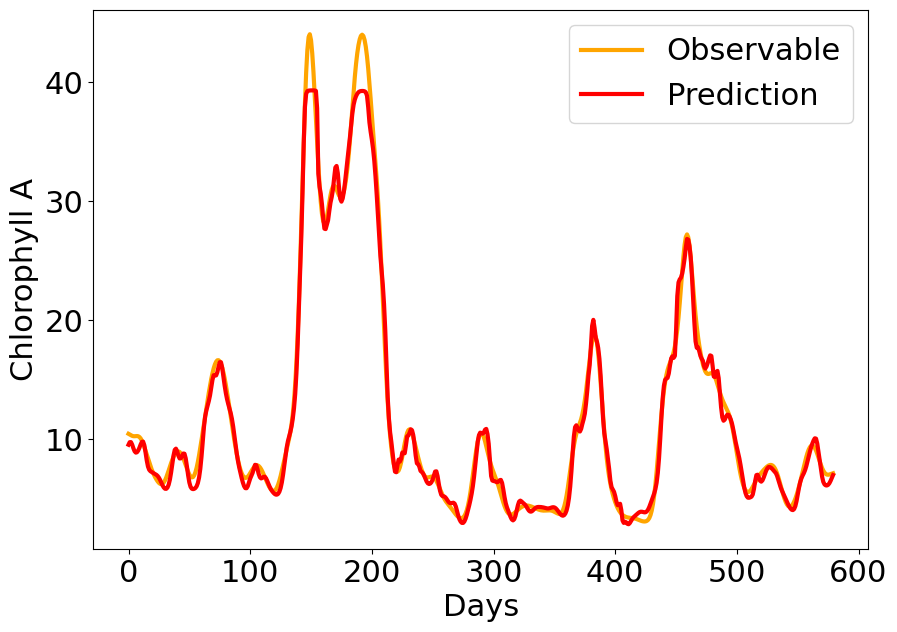

In [215]:
out, _ = model_1(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()


In [216]:
chloro = gaussian_filter1d(day_df['z6'].values,2)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps, len(chloro)-6):
    X.append(chloro[i-n_steps:i])
    Y.append(chloro[i+6])
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

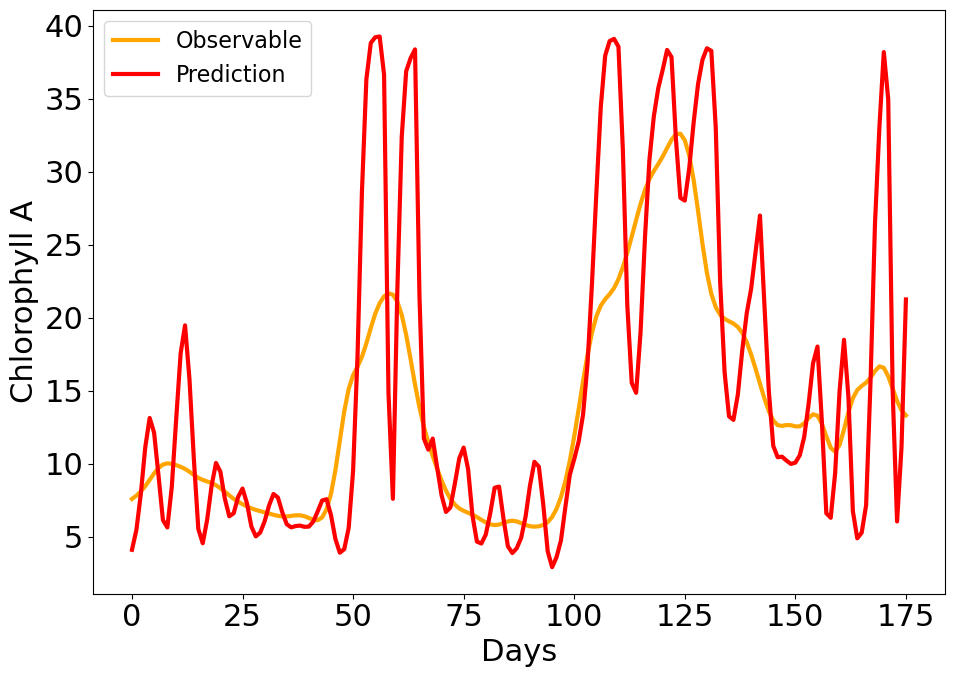

In [217]:
out, _ = model_1(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Abstest.png')
#fig.savefig('TrainTestExample.png')

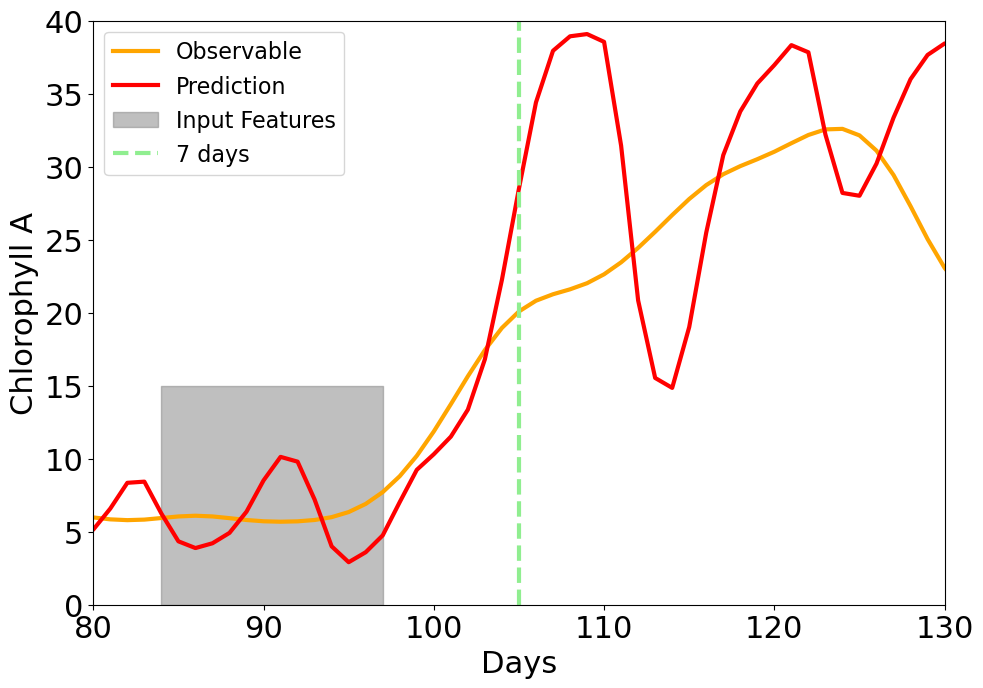

In [219]:
out, _ = model_1(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([80,130])
ax.set_ylim([0,40])
ax.fill_between(range(84,98),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(105,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Abstest7.png')
#fig.savefig('TrainTestExample.png')

# Change and study the relative change

In [131]:
[np.maximum(np.minimum((chloro[i-n_steps:i] - chloro[i-1-n_steps:i-1]) / chloro[i-1-n_steps:i-1],2),-2) for i in range(n_steps+1, len(chloro))]

[array([ 0.00304011, -0.00688945, -0.01750497, -0.02579538, -0.02837572,
        -0.02355719, -0.01367858, -0.00433828,  0.00011485, -0.00061739,
        -0.00450089, -0.00869563, -0.00877509, -0.00041611]),
 array([-0.00688945, -0.01750497, -0.02579538, -0.02837572, -0.02355719,
        -0.01367858, -0.00433828,  0.00011485, -0.00061739, -0.00450089,
        -0.00869563, -0.00877509, -0.00041611,  0.01529427]),
 array([-0.01750497, -0.02579538, -0.02837572, -0.02355719, -0.01367858,
        -0.00433828,  0.00011485, -0.00061739, -0.00450089, -0.00869563,
        -0.00877509, -0.00041611,  0.01529427,  0.03041222]),
 array([-0.02579538, -0.02837572, -0.02355719, -0.01367858, -0.00433828,
         0.00011485, -0.00061739, -0.00450089, -0.00869563, -0.00877509,
        -0.00041611,  0.01529427,  0.03041222,  0.03714092]),
 array([-0.02837572, -0.02355719, -0.01367858, -0.00433828,  0.00011485,
        -0.00061739, -0.00450089, -0.00869563, -0.00877509, -0.00041611,
         0.01529427,  

In [132]:
from NN import LSTM_model_sig

In [220]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-6):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [134]:
model_2 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [135]:
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [137]:
model_2.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
for i in range(100):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_2(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))

0.24914516636157688
0.11412426461912181
0.1161797305135286
0.11460246464671338
0.11496735642319672
0.11863450871857062
0.10800032900671845
0.1056648326961145
0.10362321274890883
0.10613242999892937
0.11306066775362786
0.10639520956535045
0.1033492738967889
0.10271952911088728
0.11012312042692753
0.10002478032232556
0.1010327020481433
0.10484712438224113
0.10829891374156084
0.10231276369360212
0.10148807333093392
0.10047349596574698
0.09654917797609551
0.0994928979939998
0.09965255286238373
0.10036112105295267
0.09506650049596617
0.09769900977509478
0.10170846422241159
0.0924648433056188
0.10282388939330839
0.10243472870286197
0.08373294465805162
0.08357784061928675
0.0773469621111473
0.06274165764246901
0.04510752554370524
0.054716216145108826
0.03835361881806732
0.01640893979482863
0.013815630428263382
0.011194414684025902
0.015816018757193465
0.00996617548253821
0.006997961853949787
0.007909426819660689
0.007911469752275168
0.007447511847577479
0.00520580133968607
0.00424104744938444

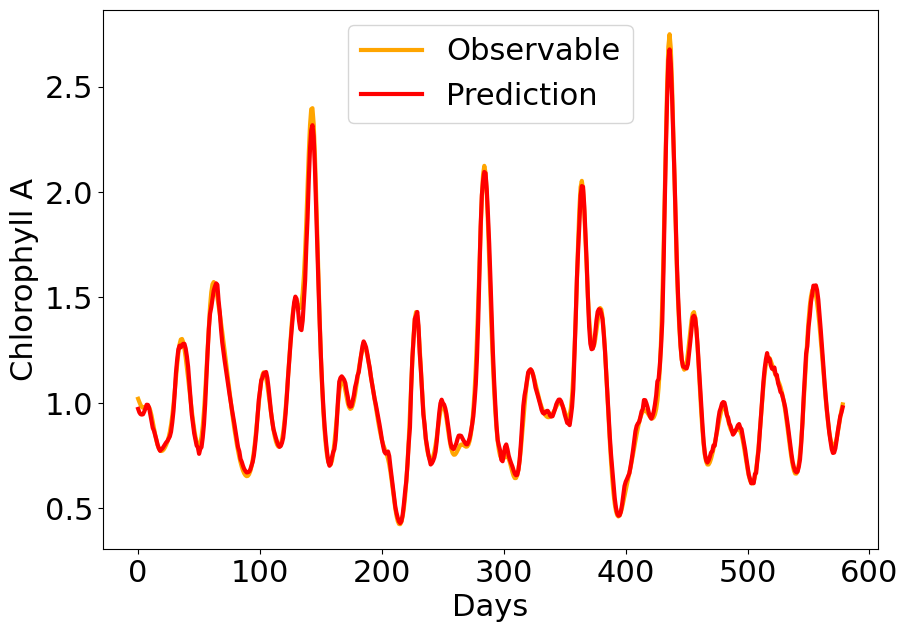

In [221]:
out, _ = model_2(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
fig.savefig('Plots/reltrain7.png')


In [223]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-6):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps:i])
    Y.append((chloro[i+6] / chloro[i-1] ))
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

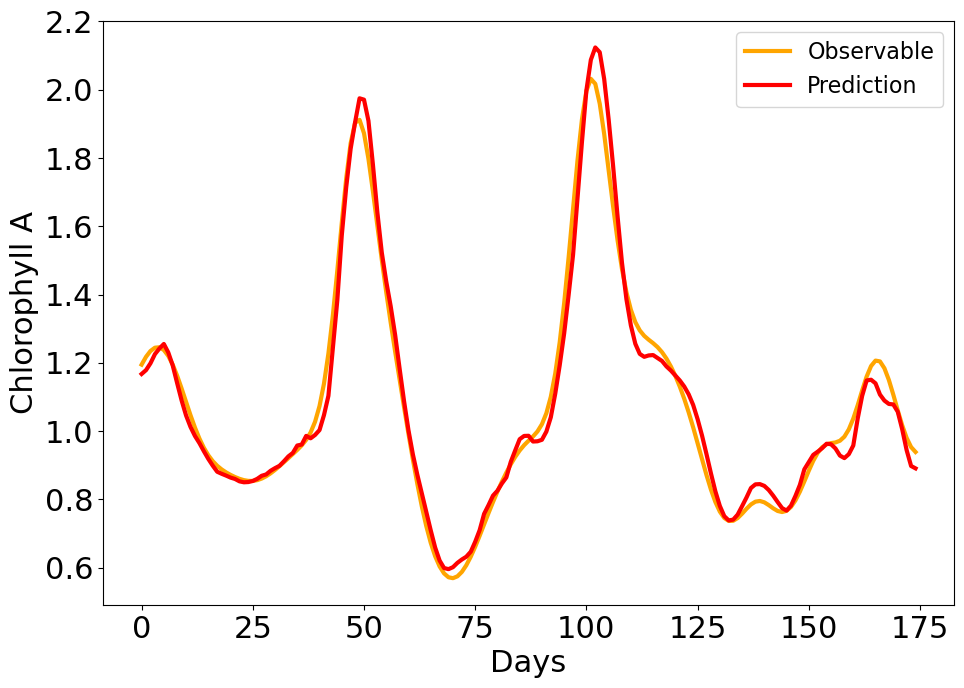

In [224]:
out, _ = model_2(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest7.png')

#fig.savefig('TrainTestExample.png')

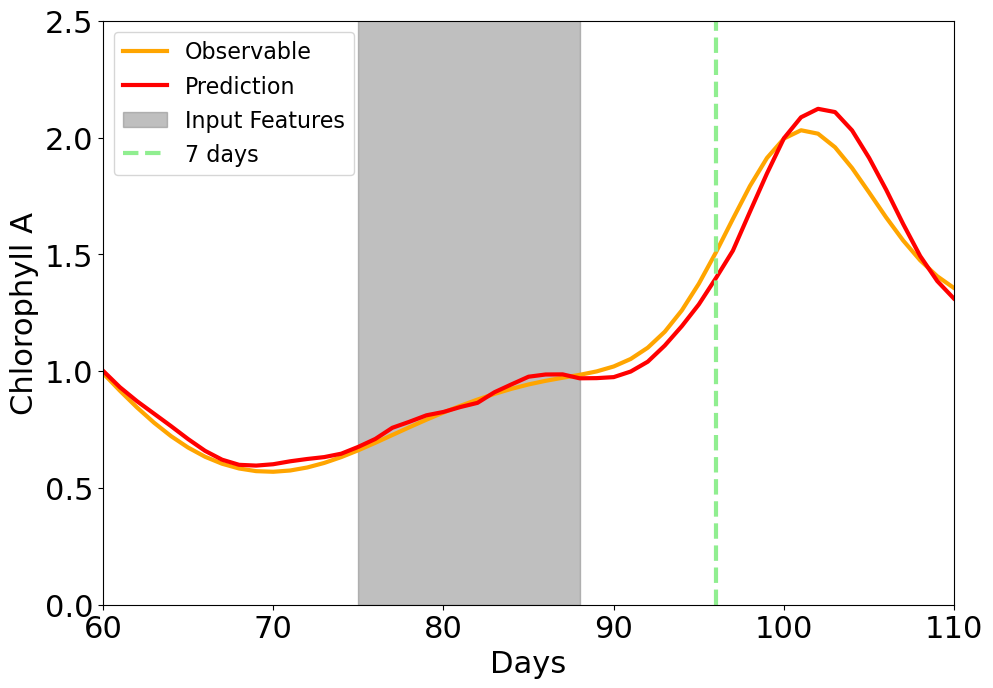

In [225]:
out, _ = model_2(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([60,110])
ax.set_ylim([0,2.5])
s = 75
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+21,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest7f.png')

#fig.savefig('TrainTestExample.png')

## Test 14 days

In [226]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-13):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+13] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

In [227]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-13):
    # X.append(chloro[i-n_steps:i])
    X.append(chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+13] / chloro[i-1] ))
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [198]:
model_3 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [199]:
model_3.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1**(1/500))
for i in range(500):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_3(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))
    scheduler.step()


0.6588273138428727
0.6020583307577504
0.6154402114657892
0.5980334787939986
0.5947478531549374
0.5988478757854965
0.5993037211139582
0.5923264401240481
0.6079990326737365
0.6055610935307212
0.5971570430426962
0.5936063170019124
0.5935596122095982
0.6052784259534545
0.5973008730345302
0.5938816350988216
0.5937335088642107
0.5906390741260515
0.6008549870716201
0.591819540804459
0.5920709828949637
0.5951140126627352
0.5966434011028873
0.6030304619214601
0.5939131344461607
0.5976749668932624
0.5922184841086467
0.5937370045317544
0.5954996917603744
0.5937324009007878
0.5941391125735309
0.593461628899806
0.5983743070521288
0.5946993987179465
0.5946267906369435
0.5922288114411963
0.5918795971406831
0.593669768422842
0.610711588524282
0.59075110219419
0.5909750907578402
0.5989551707170904
0.5940385813721352
0.5960702282480068
0.593144022135271
0.5975520776377784
0.594377287560039
0.5930795327035917
0.5982051284776794
0.608279869477782
0.5955488376526369
0.5950750700301595
0.6079072924330831
0.

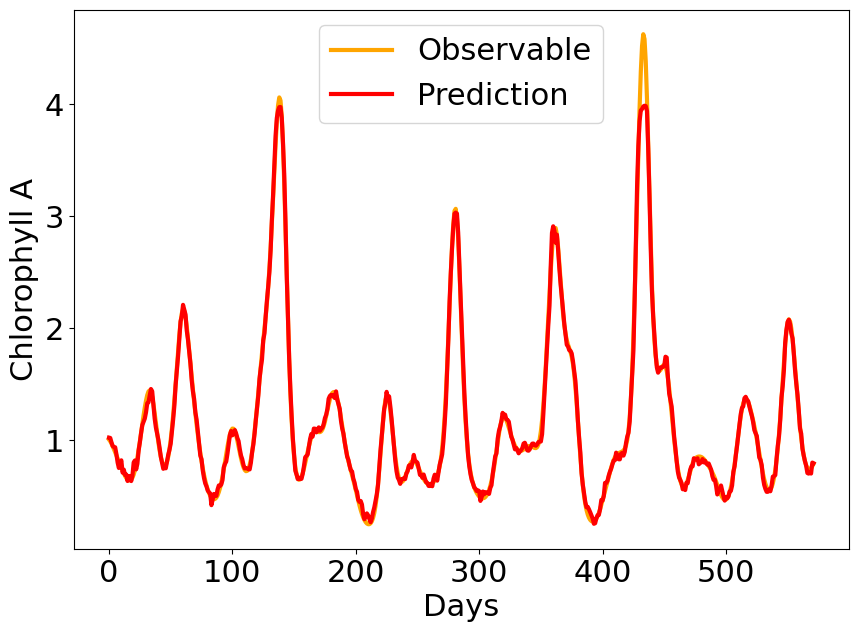

In [229]:
out, _ = model_3(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
fig.savefig('Plots/Reltrain14.png')

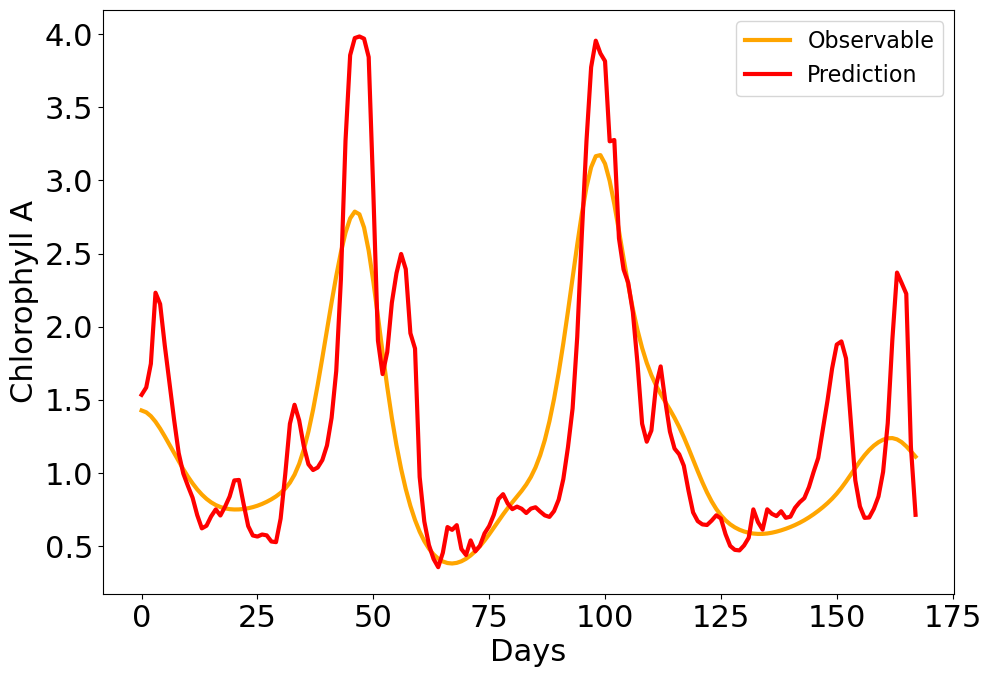

In [231]:
out, _ = model_3(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
# ax.set_xlim([130,180])
# ax.fill_between(range(139,153),0,15, alpha=0.5,color='grey',label='Input Features')
# ax.vlines(160,0,70,linestyles='dashed',colors = 'lightgreen',label='7 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltrain14.png')
#fig.savefig('TrainTestExample.png')

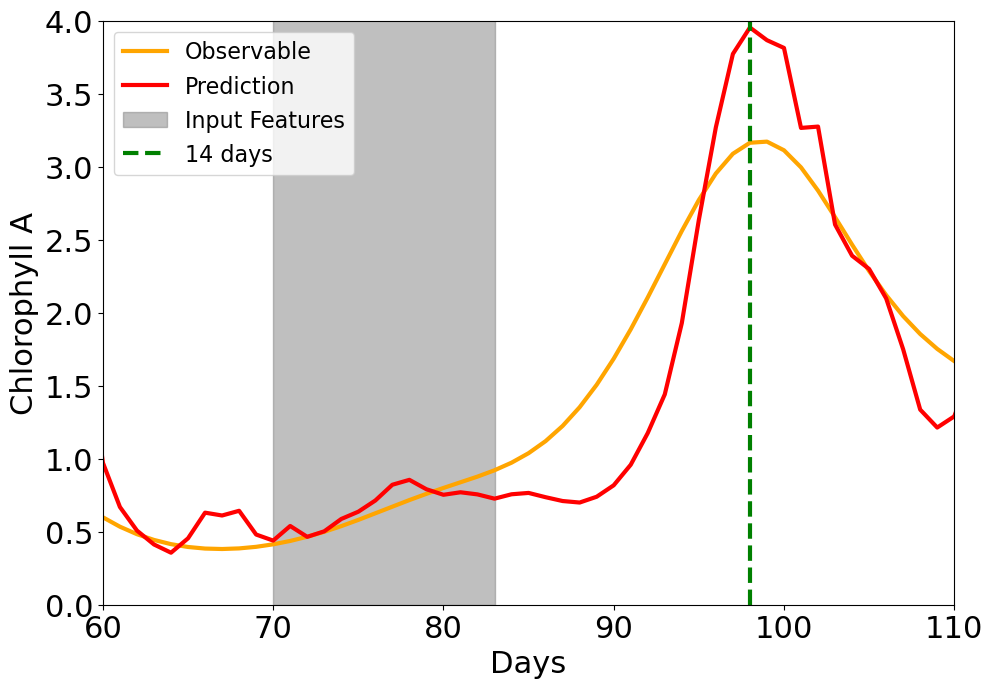

In [232]:
out, _ = model_3(X_test.T.unsqueeze(2))
fig,axd = plt.subplot_mosaic([["gaussian"]])
fig.tight_layout()
ax = axd["gaussian"]
# ax.plot(day_df['z6'].values,label='Measurement')
# ax.plot(gaussian_filter1d(day_df['z6'].values,2),label='Observable',c='orange')
ax.plot(Y_test.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')
ax.set_xlim([60,110])
ax.set_ylim([0,4])
s = 70
ax.fill_between(range(s,s+14),0,15, alpha=0.5,color='grey',label='Input Features')
ax.vlines(s+28,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(167,0,70,linestyles='dashed',colors = 'green',label='14 days')
# ax.vlines(174,0,70,linestyles='dashed',colors = 'darkgreen',label='21 days')
ax.legend(fontsize=16)
fig.savefig('Plots/Reltest14f.png')
#fig.savefig('TrainTestExample.png')

In [233]:
chloro = gaussian_filter1d(day_df['z6'].values,4)[:600]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-20):
    # X.append(chloro[i-n_steps:i])
    X.append( chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+20] / chloro[i-1] ))
X_train = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_train = torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')
ds = TensorDataset(X_train,Y_train)
dloader = DataLoader(ds,batch_size=8,shuffle=True)

chloro = gaussian_filter1d(day_df['z6'].values,4)[600:]
n_steps = 14
X, Y = [], []
for i in range(n_steps+1, len(chloro)-20):
    # X.append(chloro[i-n_steps:i])
    X.append(chloro[i-n_steps-1:i-1]/chloro[i-n_steps:i])
    Y.append((chloro[i+20] / chloro[i-1] ))
X_test = torch.tensor(np.array(X), dtype=torch.float32,device='cuda')
Y_test= torch.tensor(np.array(Y), dtype=torch.float32,device='cuda')

In [209]:
model_4 = LSTM_model_sig(1,50,5).to('cuda')
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

In [210]:
model_4.to('cuda')
X_train.to('cuda')
Y_train.to('cuda')
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.1**(1/500))
for i in range(500):
    losses = []
    for x,y in dloader:
        optimizer.zero_grad()
        out, _ = model_4(x.T.unsqueeze(2))
        lossfunction = torch.nn.MSELoss()
        loss = lossfunction(out,y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        losses.append(loss.tolist())
    print(np.mean(losses))
    scheduler.step()

1.3659321745516548
1.2823938519602092
1.2849020210789963
1.296664145211099
1.2832524509916843
1.2890110083029305
1.2830273962356675
1.284917939506786
1.2846400811218879
1.2837632923898563
1.312287775563522
1.292443607264841
1.2825619739965655
1.2824314379356276
1.3014473176338304
1.2826168318869362
1.2849912844913107
1.2830824039771522
1.2942544710887989
1.2810626605027158
1.2818726945511052
1.302038976843928
1.2823963026765366
1.288959522902126
1.285465471551452
1.285247972733538
1.2880085005726614
1.2947357523609215
1.2832349985837936
1.2942912878704742
1.2878401334017096
1.2832222988068218
1.2851418676510664
1.288924439902037
1.280024711724738
1.280566413217867
1.2815371743390258
1.2812298420869128
1.3060767617024167
1.289374137848196
1.2800307846824888
1.2798352212133541
1.300782442302771
1.2841224513003524
1.2875573251029135
1.2819958948333499
1.2817388512718846
1.283563630891518
1.2865607948370383
1.2874104221102218
1.2816648403523674
1.2887573838233948
1.2934566565172774
1.28229

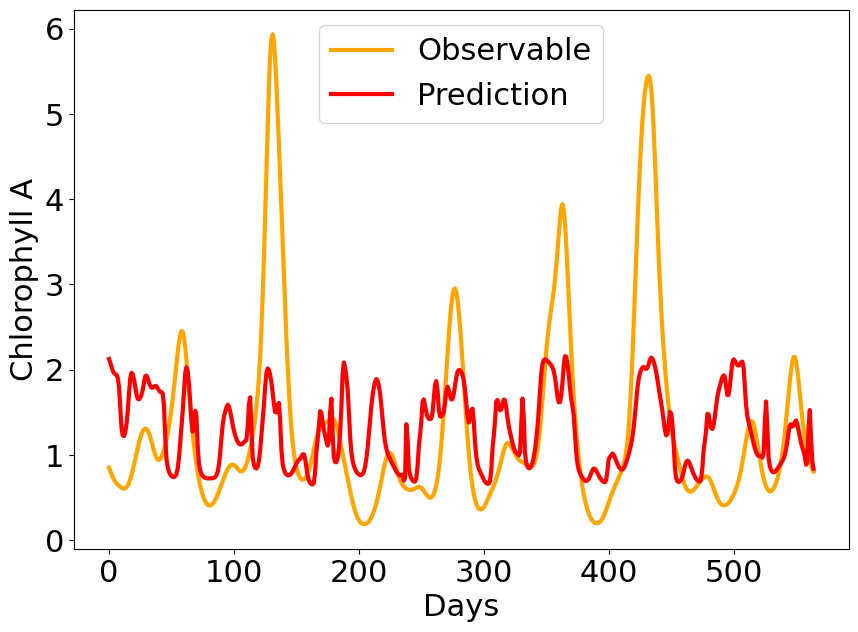

In [234]:
out, _ = model_4(X_train.T.unsqueeze(2))

fig, axd = plt.subplot_mosaic([['Prediction7days']])
ax = axd['Prediction7days']
ax.plot(Y_train.tolist(),label='Observable',color='orange')
ax.plot(out.tolist(),label='Prediction',color='red')

ax.set_xlabel('Days')
ax.set_ylabel('Chlorophyll A')

plt.legend()
plt.xlim()
fig.savefig('Plots/Reltrain21.png')